In [1]:
# Import libraries
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import os, glob, pickle
import IPython.display as ipd 
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import sys
import warnings

import soundfile
import seaborn as sns
import pandas as pd

# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 12
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def model_loss(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
    def model_acc(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['acc'])
        plt.plot(model_history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)
        
    def accuracy_results_emotions(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })
        preds = pd.DataFrame(preds).replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)
        

In [3]:
ref = pd.read_csv("../datasets/data_path.csv")
ref.head()

,labels,source,path
0,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
1,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
2,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
3,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...
4,male_neutral,RAVDESS,../datasets/RAVDESS/audio_speech_actors_01-24/...


MFCC without augmentation

In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 8690/8690 [04:18<00:00, 33.57it/s]


In [5]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, epochs=20)

Epoch 1/20
408/408 [==============================] - 73s 175ms/step - loss: 2.5898 - acc: 0.1333 - val_loss: 2.0879 - val_acc: 0.2531
Epoch 2/20
408/408 [==============================] - 70s 171ms/step - loss: 1.9707 - acc: 0.2882 - val_loss: 1.6854 - val_acc: 0.3769
Epoch 3/20
408/408 [==============================] - 69s 170ms/step - loss: 1.7338 - acc: 0.3580 - val_loss: 1.5844 - val_acc: 0.4100
Epoch 4/20
408/408 [==============================] - 70s 172ms/step - loss: 1.6103 - acc: 0.3886 - val_loss: 1.4284 - val_acc: 0.4643
Epoch 5/20
408/408 [==============================] - 69s 170ms/step - loss: 1.5340 - acc: 0.4229 - val_loss: 1.3914 - val_acc: 0.4892
Epoch 6/20
408/408 [==============================] - 70s 170ms/step - loss: 1.4745 - acc: 0.4521 - val_loss: 1.3729 - val_acc: 0.4841
Epoch 7/20
408/408 [==============================] - 70s 170ms/step - loss: 1.4269 - acc: 0.4639 - val_loss: 1.3197 - val_acc: 0.5071
Epoch 8/20
408/408 [==============================] - 7

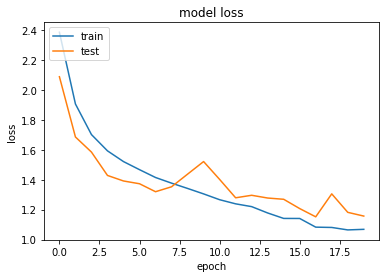

In [6]:
results_mfcc = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results_mfcc.model_loss(model_history)


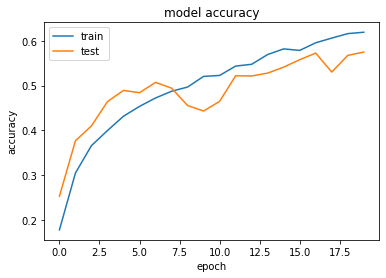

In [7]:
results_mfcc.model_acc(model_history)

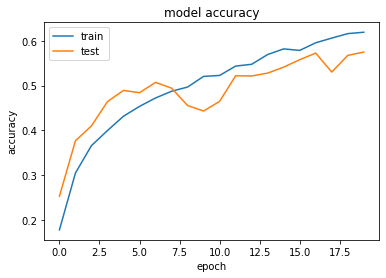

In [8]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

accuracy: 57.48%
136/136 - 3s


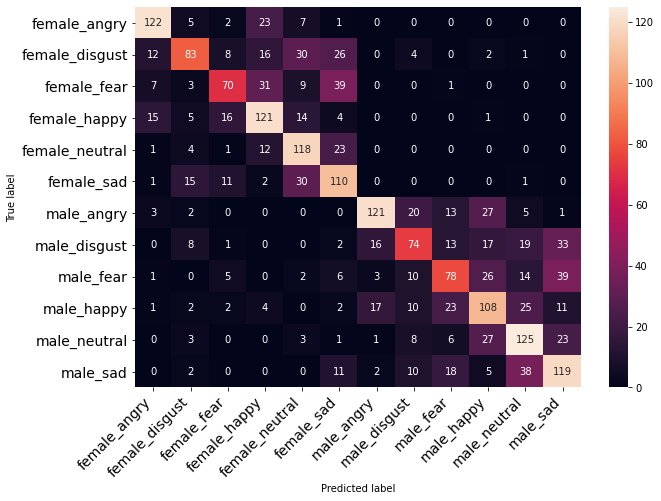

In [9]:
results_mfcc.create_results(model)
results_mfcc.confusion_results(X_test, y_test, ref.labels.unique(), model)

MFCC with Augmentation

In [10]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 8690/8690 [04:43<00:00, 30.62it/s]


In [11]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, epochs=20)

Epoch 1/20
408/408 [==============================] - 71s 172ms/step - loss: 2.5311 - acc: 0.1492 - val_loss: 2.1672 - val_acc: 0.2172
Epoch 2/20
408/408 [==============================] - 70s 173ms/step - loss: 2.0553 - acc: 0.2678 - val_loss: 1.9002 - val_acc: 0.3065
Epoch 3/20
408/408 [==============================] - 69s 170ms/step - loss: 1.8977 - acc: 0.2998 - val_loss: 1.8567 - val_acc: 0.3341
Epoch 4/20
408/408 [==============================] - 69s 169ms/step - loss: 1.7837 - acc: 0.3416 - val_loss: 1.6892 - val_acc: 0.3820
Epoch 5/20
408/408 [==============================] - 70s 171ms/step - loss: 1.7370 - acc: 0.3621 - val_loss: 1.9321 - val_acc: 0.2816
Epoch 6/20
408/408 [==============================] - 70s 171ms/step - loss: 1.6797 - acc: 0.3824 - val_loss: 1.6537 - val_acc: 0.4114
Epoch 7/20
408/408 [==============================] - 69s 170ms/step - loss: 1.6356 - acc: 0.4039 - val_loss: 1.7124 - val_acc: 0.3046
Epoch 8/20
408/408 [==============================] - 7

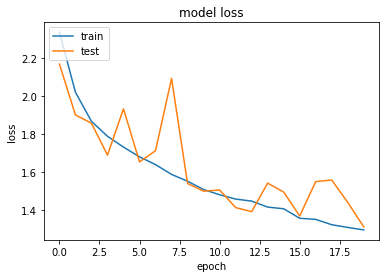

In [12]:
results_mfcc_aug = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results_mfcc_aug.model_loss(model_history)


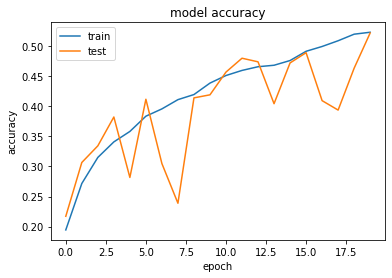

In [13]:
results_mfcc_aug.model_acc(model_history)

accuracy: 52.14%
136/136 - 4s


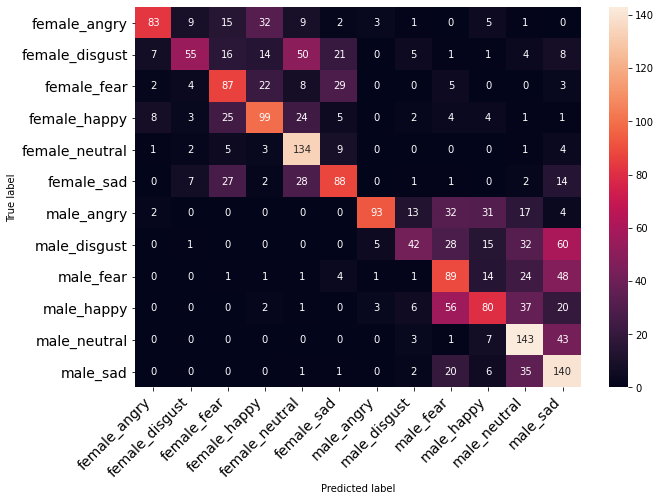

In [14]:
results_mfcc_aug.create_results(model)
results_mfcc_aug.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [15]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
specgram = prepare_data(ref, n = n_melspec, aug = 0, mfcc = 0)

100%|██████████| 8690/8690 [04:56<00:00, 29.34it/s]


In [16]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, epochs=20)

Epoch 1/20
408/408 [==============================] - 143s 348ms/step - loss: 2.4695 - acc: 0.1510 - val_loss: 2.1776 - val_acc: 0.2476
Epoch 2/20
408/408 [==============================] - 136s 334ms/step - loss: 2.0995 - acc: 0.2457 - val_loss: 2.0556 - val_acc: 0.2683
Epoch 3/20
408/408 [==============================] - 138s 339ms/step - loss: 1.9019 - acc: 0.3015 - val_loss: 1.6610 - val_acc: 0.3824
Epoch 4/20
408/408 [==============================] - 138s 337ms/step - loss: 1.8195 - acc: 0.3295 - val_loss: 1.6664 - val_acc: 0.3852
Epoch 5/20
408/408 [==============================] - 140s 343ms/step - loss: 1.6623 - acc: 0.3958 - val_loss: 1.5795 - val_acc: 0.4114
Epoch 6/20
408/408 [==============================] - 142s 348ms/step - loss: 1.5745 - acc: 0.4117 - val_loss: 1.5712 - val_acc: 0.4266
Epoch 7/20
408/408 [==============================] - 140s 342ms/step - loss: 1.5098 - acc: 0.4522 - val_loss: 1.4741 - val_acc: 0.4482
Epoch 8/20
408/408 [============================

In [17]:
results_specgram = get_results(model_history,model,X_test,y_test, ref.labels.unique())


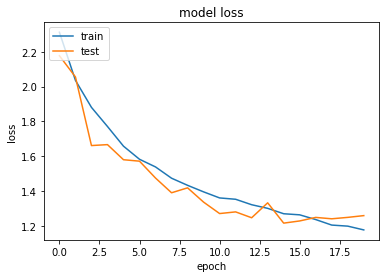

In [18]:
results_specgram.model_loss(model_history)

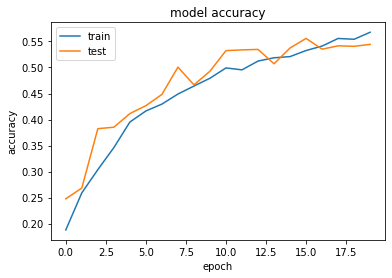

In [19]:
results_specgram.model_acc(model_history)

accuracy: 54.44%
136/136 - 6s


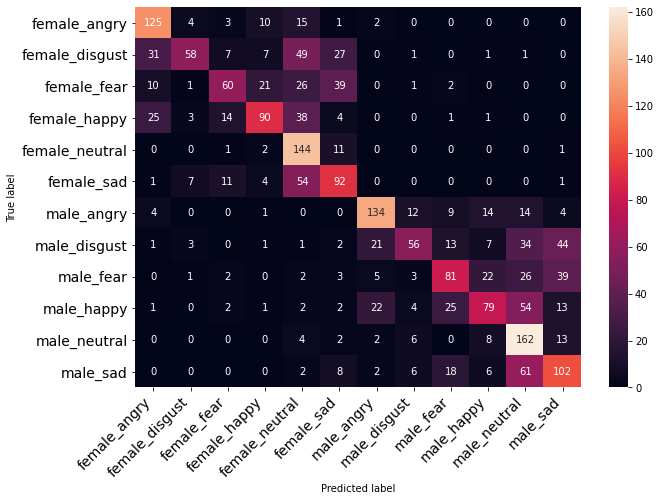

In [20]:
results_specgram.create_results(model)
results_specgram.confusion_results(X_test, y_test, ref.labels.unique(), model)

 Log-melspectogram with augmentation

In [21]:
sampling_rate=44100
audio_duration=2.5
n_melspec = 60
aug_specgram = prepare_data(ref,  n = n_melspec, aug = 1, mfcc = 0)

100%|██████████| 8690/8690 [03:56<00:00, 36.75it/s]


In [22]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(aug_specgram
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_melspec)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, epochs=20)

Epoch 1/20
408/408 [==============================] - 137s 333ms/step - loss: 2.4794 - acc: 0.1475 - val_loss: 2.3754 - val_acc: 0.1689
Epoch 2/20
408/408 [==============================] - 138s 337ms/step - loss: 2.0400 - acc: 0.2595 - val_loss: 1.7905 - val_acc: 0.3613
Epoch 3/20
408/408 [==============================] - 145s 355ms/step - loss: 1.9163 - acc: 0.2922 - val_loss: 1.9863 - val_acc: 0.2977
Epoch 4/20
408/408 [==============================] - 141s 345ms/step - loss: 1.8199 - acc: 0.3313 - val_loss: 1.7727 - val_acc: 0.3590
Epoch 5/20
408/408 [==============================] - 136s 333ms/step - loss: 1.7499 - acc: 0.3579 - val_loss: 1.6895 - val_acc: 0.3847
Epoch 6/20
408/408 [==============================] - 151s 369ms/step - loss: 1.6864 - acc: 0.3757 - val_loss: 1.6207 - val_acc: 0.4004
Epoch 7/20
408/408 [==============================] - 146s 357ms/step - loss: 1.6712 - acc: 0.3869 - val_loss: 1.6330 - val_acc: 0.4133
Epoch 8/20
408/408 [============================

In [23]:
results_aug_specgram = get_results(model_history,model,X_test,y_test, ref.labels.unique())

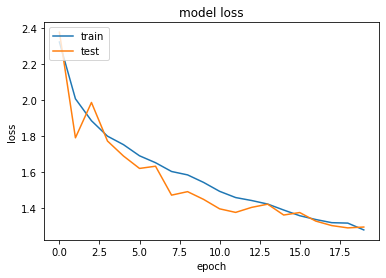

In [24]:
results_aug_specgram.model_loss(model_history)

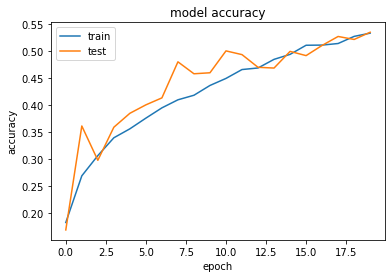

In [25]:
results_aug_specgram.model_acc(model_history)

accuracy: 53.47%
136/136 - 6s


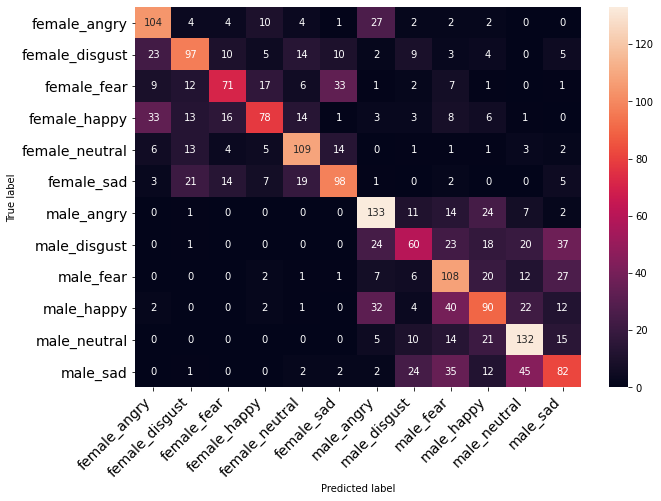

In [26]:
results_aug_specgram.create_results(model)
results_aug_specgram.confusion_results(X_test, y_test, ref.labels.unique(), model)

136/136 - 6s
0.9443166129774505


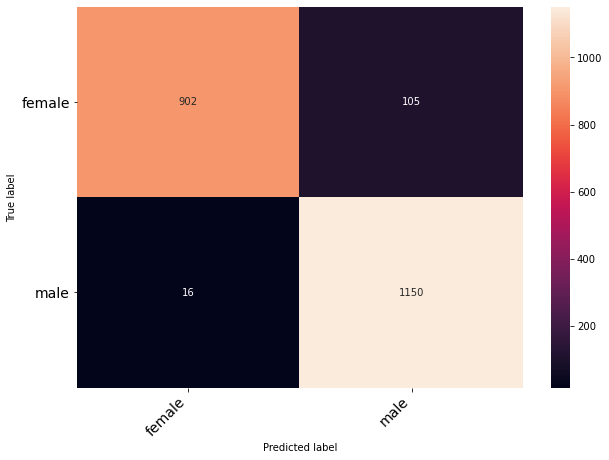

In [27]:
results_specgram.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)

136/136 - 6s
0.563276576161988


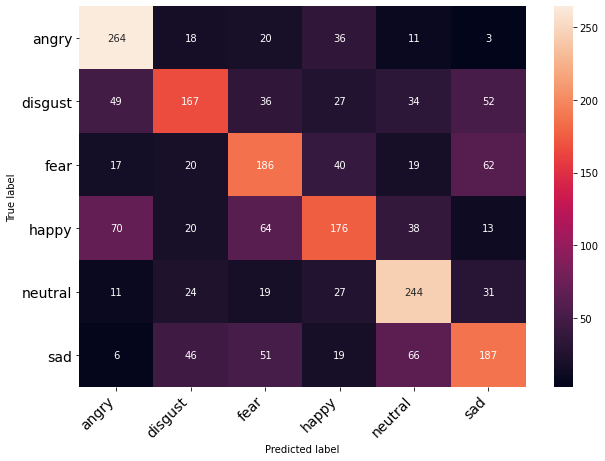

In [28]:
results_specgram.accuracy_results_emotions(X_test, y_test, ref.labels.unique(), model)

136/136 - 6s
0.9443166129774505


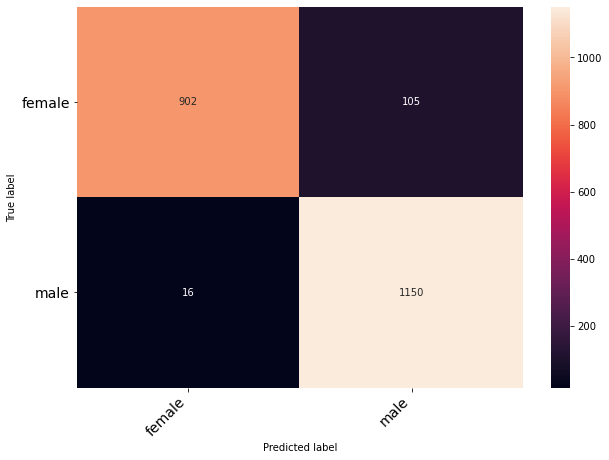

In [31]:
results_mfcc.accuracy_results_gender(X_test, y_test, ref.labels.unique(), model)

136/136 - 6s
0.563276576161988


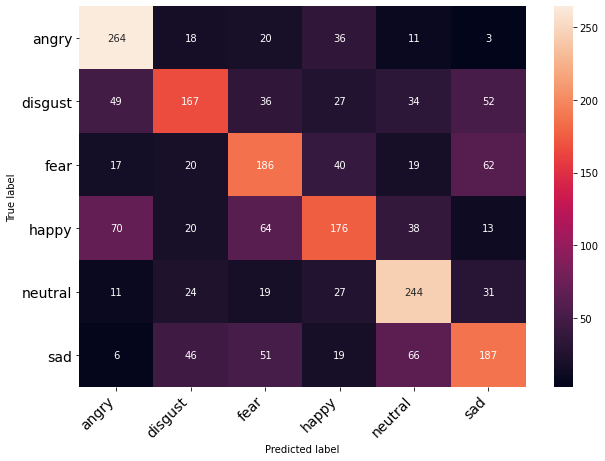

In [30]:
results_mfcc.accuracy_results_emotions(X_test, y_test, ref.labels.unique(), model)

In [29]:
#         preds = model.predict(X_test, 
#                          batch_size=16, 
#                          verbose=2)
#         preds=preds.argmax(axis=1)
#         preds = preds.astype(int).flatten()
#         preds = (lb.inverse_transform((preds)))

#         actual = y_test.argmax(axis=1)
#         actual = actual.astype(int).flatten()
#         actual = (lb.inverse_transform((actual)))
        
#         # print(accuracy_score(actual, preds))
        
#         actual = pd.DataFrame(actual).replace({'female_angry':'angry'
#                                        , 'female_disgust':'disgust'
#                                        , 'female_fear':'fear'
#                                        , 'female_happy':'happy'
#                                        , 'female_sad':'sad'
#                                        , 'female_surprise':'surprise'
#                                        , 'female_neutral':'neutral'
#                                        , 'male_angry':'angry'
#                                        , 'male_fear':'fear'
#                                        , 'male_happy':'happy'
#                                        , 'male_sad':'sad'
#                                        , 'male_surprise':'surprise'
#                                        , 'male_neutral':'neutral'
#                                        , 'male_disgust':'disgust'
#                                       })
#         preds = pd.DataFrame(preds).replace({'female_angry':'angry'
#                                        , 'female_disgust':'disgust'
#                                        , 'female_fear':'fear'
#                                        , 'female_happy':'happy'
#                                        , 'female_sad':'sad'
#                                        , 'female_surprise':'surprise'
#                                        , 'female_neutral':'neutral'
#                                        , 'male_angry':'angry'
#                                        , 'male_fear':'fear'
#                                        , 'male_happy':'happy'
#                                        , 'male_sad':'sad'
#                                        , 'male_surprise':'surprise'
#                                        , 'male_neutral':'neutral'
#                                        , 'male_disgust':'disgust'
#                                       })

#         classes = actual.loc[:,0].unique() 
#         classes.sort()    

#         c = confusion_matrix(actual, preds)
#         print(accuracy_score(actual, preds))
#         print_confusion_matrix(c, class_names = classes)
        